Fit of the grow rate $f$ from redshfit space distorsion of the power spectrum of BOSS' catalogues computed with Euclid's code 

The model that I am going to fit is teh following

$P_g(k,\mu) = exp(-(fk\mu\sigma_v)^2)(b_1 + f\mu^2)P_{dw}$ (1) 

where $P_{dw}$ is the power spectrum de-wiggled, adn the free parameters to fitting are $f$, $b_1$ and $\sigma_v$

The euclid code returns the multipoles of the power spectrum, so I decompose the anistropic power spectrum showed in (1) in multipoles:

$P_\ell(k) = \frac{(2*\ell + 1)}{2}\int_{-1}^{1} d\mu P(k,\mu) \mathscr{L}_\ell(\mu)$

I am going to fit $P_\ell$ with the covariance matrix that I computed in set_covariance code

In [2]:
from MElCorr import MElCorrCpp as melcpp
import MElCorr.MElCorrPy as melpy
import numpy as np
import matplotlib.pyplot as plt
import camb
import scipy
from tqdm.notebook import tqdm
from GaussianCovariance import *
from scipy.special import legendre
import hankl
import iminuit

First of all I create the model of the power spectrum that I am going to fit 

In [3]:
eh = melpy.EisensteinHu()

$P_{dw}$ is the power spectrum with damped BAO wiggles and I compute it from a linear power spectrum computed by CAMB with BOSS fiducial cosmology. 

$P_{dw} = P_{nw} + (1 + k^2\Sigma^2)e^{(-k^2\Sigma^2)}(P - P_{nw})$

In [4]:
omb_fid = 0.048
h_fid = 0.676
omc_fid = 0.31 - omb_fid
sigma8_fid = 0.824
T_CMB=2.725

In [5]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h_fid, ombh2=omb_fid*h_fid**2, omch2=omc_fid*h_fid**2)
pars.set_matter_power(redshifts=[0.], kmax=2.0)
results = camb.get_results(pars)
sigma8=camb.get_results(pars).get_sigma8()
pars.InitPower.set_params(As=2e-9*sigma8_fid**2/sigma8**2, ns=0.965)
pars.set_matter_power(redshifts=[0.38], kmax=2.0)
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)

In [6]:
eh.set_params(omega_m=omb_fid + omc_fid, omega_b=omb_fid, h=h_fid, ns=0.965, sigma8=results.get_sigma8()[0], T_CMB=2.725)
pk_nw = eh.power_spectrum(kh)
P_nw = scipy.interpolate.interp1d(kh, pk_nw, kind='cubic', fill_value='extrapolate')
Sigma = melpy.utilities.compute_sigma2(P_nw)
damp = (1 + kh**2*Sigma)*np.exp(-kh**2*Sigma)
pk_dw = pk_nw + damp*(pk[0] - pk_nw)

In [9]:
PK_dw = scipy.interpolate.interp1d(kh, pk_dw, kind='cubic', fill_value='extrapolate')

In [10]:
b1 = 2.0
f = 0.71
sigma_v= 3.0
p_k_mu = lambda k, mu: (b1 + f*mu**2)**2*PK_dw(k)*np.exp(-f*k**2*mu**2*sigma_v**2)

In [11]:
deg = 51

mu, weights = np.polynomial.legendre.leggauss(deg)
l_list = [0,2,4]

In [12]:
def p_l(l_list, kk):
    p_k_l ={}
    for ll in l_list:
        leg = legendre(ll)(mu)
        p_k_l[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu(k, mu) * leg)  for k in kk]) 
    return p_k_l

In [14]:
real_model = p_l(l_list, kh)

Text(0, 0.5, 'P(k)[Mpc/h]^3')

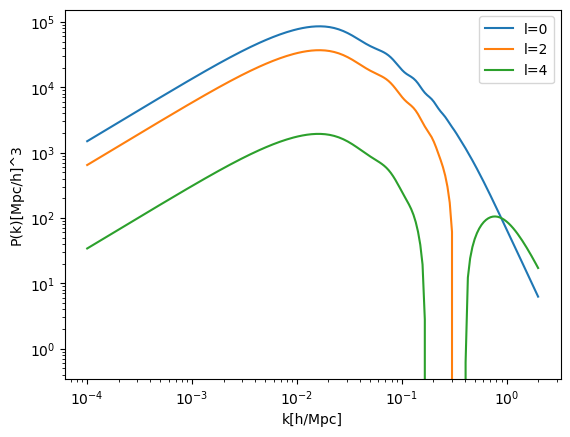

In [15]:
plt.loglog(kh, real_model[0], label='l=0')
plt.loglog(kh, real_model[2], label='l=2')
plt.loglog(kh, real_model[4], label='l=4')
plt.legend()
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')


load data

In [25]:
k_eff = np.load('npy_pk/k_eff.npy')
ngc_z1_monopole = np.load('npy_pk/monopole/NGC_z1.npy')
ngc_z1_quadrupole = np.load('npy_pk/quadrupole/NGC_z1.npy')
sgc_z1_monopole = np.load('npy_pk/monopole/SGC_z1.npy')
sgc_z1_quadrupole = np.load('npy_pk/quadrupole/SGC_z1.npy')
cov_ngc_z1 = np.load('Covariance_matrix/cov_pk_Nz1.npy')
cov_sgc_z1 = np.load('Covariance_matrix/cov_pk_Sz1.npy')

Define the likelihood

In [22]:
def log_likelihood(theta,data, inv_cov):
    b_nord, f, sigma_v_nord, b_south, sigma_v_south = theta
    p_k_mu_north = lambda k, mu: (b_nord + f*mu**2)**2*PK_dw(k)*np.exp(-f*k**2*mu**2*sigma_v_nord**2)
    p_k_mu_south = lambda k, mu: (b_south + f*mu**2)**2*PK_dw(k)*np.exp(-f*k**2*mu**2*sigma_v_south**2)
    p_k_l_north ={}
    p_k_l_south ={}
    for ll in l_list:
        leg = legendre(ll)(mu)
        p_k_l_north[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_north(k, mu) * leg)  for k in kh])
        p_k_l_south[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_south(k, mu) * leg)  for k in kh]) 
    #model_big = p_l(l_list, kh)
    model1_N = scipy.interpolate.interp1d(kh, p_k_l_north[0], kind='cubic', fill_value='extrapolate')
    model2_N = scipy.interpolate.interp1d(kh, p_k_l_north[2], kind='cubic', fill_value='extrapolate')
    model1_S = scipy.interpolate.interp1d(kh, p_k_l_south[0], kind='cubic', fill_value='extrapolate')
    model2_S = scipy.interpolate.interp1d(kh, p_k_l_south[2], kind='cubic', fill_value='extrapolate')
    model = np.concatenate([model1_N(k_eff), model2_N(k_eff), model1_S(k_eff), model2_S(k_eff)])
    residual = data - model
    return -0.5*np.dot(residual, np.dot(inv_cov, residual))

In [35]:
data = np.concatenate([ngc_z1_monopole, ngc_z1_quadrupole, sgc_z1_monopole, sgc_z1_quadrupole])
inv_cov_ngc_z1 = np.linalg.inv(cov_ngc_z1)
inv_cov_sgc_z1 = np.linalg.inv(cov_sgc_z1)
inv_cov = scipy.linalg.block_diag(inv_cov_ngc_z1, inv_cov_sgc_z1)

In [36]:
data.shape

(72,)

In [37]:
inv_cov.shape

(72, 72)

In [38]:
#initialize the parameters
b1_N = 2.0
f = 0.71
sigma_v_N = 3.0
b1_S = 2.0
sigma_v_S = 3.0

I use Iminuit to minimize $\chi^2$

In [40]:
def chi2(b_nord, f, sigma_v_nord, b_south, sigma_v_south):
    return -2*log_likelihood([b_nord, f, sigma_v_nord, b_south, sigma_v_south], data, inv_cov)

initial = [b1_N, f, sigma_v_N, b1_S, sigma_v_S]

m = iminuit.Minuit(chi2, *initial)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 82.13                      │              Nfcn = 212              │
│ EDM = 2.7e-05 (Goal: 0.0002)     │            time = 5.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b_nord        │   1.943   │   0.009   │            │            │         │         │       │
│ 1 │ f             │   0.524   │   0.017   │            │            │         │         │       │
│ 2 │ sigma_v_nord  │    0.0    │    0.7    │            │            │         │         │       │
│ 3 │ b_south       │   1.889   │   0.013   │            │            │         │         │       │
│ 4 │ sigma_v_south │    2.2    │    0.8    │            │            │         │         │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬───────────────────────────────────────────────────────────────────────┐
│               │        b_nord             f  sigma_v_nord       b_south sigma_v_south │
├───────────────┼───────────────────────────────────────────────────────────────────────┤
│        b_nord │      7.52e-05      -0.11e-3             0       0.02e-3      -1.87e-3 │
│             f │      -0.11e-3      0.000301       0.01e-3      -0.04e-3       4.95e-3 │
│  sigma_v_nord │             0       0.01e-3         0.487            -0           0.0 │
│       b_south │       0.02e-3      -0.04e-3            -0      0.000173       5.50e-3 │
│ sigma_v_south │      -1.87e-3       4.95e-3           0.0       5.50e-3          0.58 │
└───────────────┴───────────────────────────────────────────────────────────────────────┘

In [41]:
#chi2 
chi2_min = m.fval
ndof = len(data) - 5
reduced_chi2 = chi2_min / ndof

In [59]:
from IPython.display import display, Markdown

display(Markdown(r'$b_1^N$ = {:.5f} +- {:.5f}'.format(m.values[0], m.errors[0])))
display(Markdown(r'$f$ = {:.5f} +- {:.5f}'.format(m.values[1], m.errors[1])))
display(Markdown(r'$\sigma_v^N$ = {:.5f} +- {:.5f}'.format(m.values[2], m.errors[2])))
display(Markdown(r'$b_1^S$ = {:.5f} +- {:.5f}'.format(m.values[3], m.errors[3])))
display(Markdown(r'$\sigma_v^S$ = {:.5f} +- {:.5f}'.format(m.values[4], m.errors[4])))
display(Markdown(r'$\chi^2$ = {:.5f}'.format(chi2_min)))
display(Markdown(r'$ndof$ = {}'.format(ndof)))
display(Markdown(r'reduced $\chi^2$ = {:.5f}'.format(reduced_chi2)))




$b_1^N$ = 1.94262 +- 0.00867

$f$ = 0.52428 +- 0.01735

$\sigma_v^N$ = 0.00058 +- 0.69769

$b_1^S$ = 1.88903 +- 0.01317

$\sigma_v^S$ = 2.20040 +- 0.76155

$\chi^2$ = 82.13109

$ndof$ = 67

reduced $\chi^2$ = 1.22584

In [47]:
b1_fit_N = m.values[0]
f_fit = m.values[1]
sigma_v_fit_N = m.values[2]
b1_fit_S = m.values[3]
sigma_v_fit_S = m.values[4]

In [48]:
p_k_mu_fit_N = lambda k, mu: (b1_fit_N + f_fit*mu**2)**2*PK_dw(k)*np.exp(-f_fit*k**2*mu**2*sigma_v_fit_N**2)
p_k_mu_fit_S = lambda k, mu: (b1_fit_S + f_fit*mu**2)**2*PK_dw(k)*np.exp(-f_fit*k**2*mu**2*sigma_v_fit_S**2)
p_k_l_fit_N ={}
p_k_l_fit_S ={}
for ll in l_list:
    leg = legendre(ll)(mu)
    p_k_l_fit_N[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_fit_N(k, mu) * leg)  for k in kh])
    p_k_l_fit_S[ll] = 0.5 * (2*ll+1) * np.array([np.sum(weights * p_k_mu_fit_S(k, mu) * leg)  for k in kh])

In [50]:
interp_pk_N_1 = scipy.interpolate.interp1d(kh, p_k_l_fit_N[0], kind='cubic', fill_value='extrapolate')
interp_pk_N_2 = scipy.interpolate.interp1d(kh, p_k_l_fit_N[2], kind='cubic', fill_value='extrapolate')
interp_pk_S_1 = scipy.interpolate.interp1d(kh, p_k_l_fit_S[0], kind='cubic', fill_value='extrapolate')
interp_pk_S_2 = scipy.interpolate.interp1d(kh, p_k_l_fit_S[2], kind='cubic', fill_value='extrapolate')

Plot the best fit model with the data

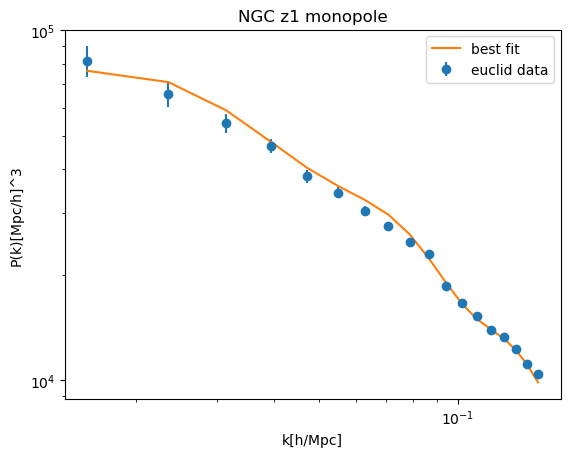

In [55]:
plt.errorbar(k_eff, ngc_z1_monopole, yerr=np.sqrt(np.diag(cov_ngc_z1))[:len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_N_1(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('NGC z1 monopole')    
plt.xscale('log')
plt.yscale('log')
plt.legend()


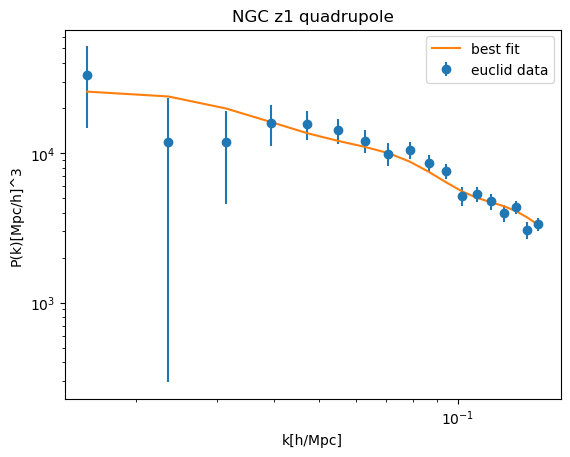

In [56]:
plt.errorbar(k_eff, ngc_z1_quadrupole, yerr=np.sqrt(np.diag(cov_ngc_z1))[len(k_eff):2*len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_N_2(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('NGC z1 quadrupole')
plt.xscale('log')
plt.yscale('log')
plt.legend()    

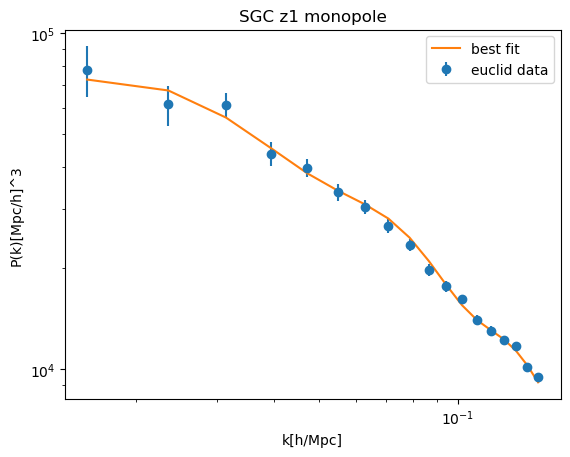

In [57]:
plt.errorbar(k_eff, sgc_z1_monopole, yerr=np.sqrt(np.diag(cov_sgc_z1))[:len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_S_1(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('SGC z1 monopole')
plt.xscale('log')
plt.yscale('log')
plt.legend()

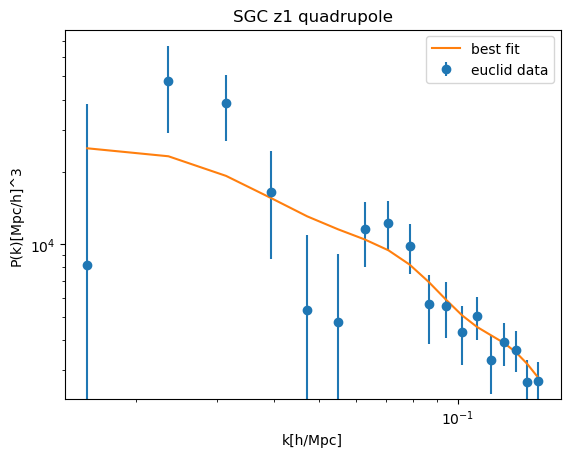

In [58]:
plt.errorbar(k_eff, sgc_z1_quadrupole, yerr=np.sqrt(np.diag(cov_sgc_z1))[len(k_eff):2*len(k_eff)], fmt='o', label='euclid data')
plt.plot(k_eff, interp_pk_S_2(k_eff), label='best fit')
plt.xlabel('k[h/Mpc]')
plt.ylabel('P(k)[Mpc/h]^3')
plt.title('SGC z1 quadrupole')
plt.xscale('log')
plt.yscale('log')
plt.legend()